In [24]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

In [3]:
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
}

In [4]:
## This is function to draw nba_court
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [5]:
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
# Select the dictionary for the Heat, which contains their team ID
heat = [team for team in nba_teams if team['abbreviation'] == 'MIA'][0]
heat_id = heat['id']
print(heat_id)

1610612748


In [6]:
from nba_api.stats.endpoints import leaguegamefinder
#Query for games where the Heat were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=heat_id, headers=headers)
# The first DataFrame of those returned is what we want.
heat_games = gamefinder.get_data_frames()[0]
heat_games.head()
heat_gameids = heat_games['GAME_ID'].values

In [7]:
from nba_api.stats.endpoints import boxscoreadvancedv2

bs = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id='0021900126', headers=headers).get_json()
boxscore = json.loads(bs)
TEAM = 1
PLAYER = 0
player_stats = boxscore["resultSets"][PLAYER]["rowSet"]
stat_headers = boxscore["resultSets"][PLAYER]["headers"]
team_stats = boxscore["resultSets"][TEAM]["rowSet"]
teamStat_header = boxscore["resultSets"][TEAM]["headers"]

In [8]:
## Build the team name to team_id map
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1
print(team_to_id)

{'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739, 'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742, 'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745, 'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751, 'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757, 'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760, 'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763, 'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766}


In [10]:
# Franchise leaders
from nba_api.stats.endpoints import franchiseleaders
fl = franchiseleaders.FranchiseLeaders(team_id=team_to_id["MIA"], headers=headers)
leaders = fl.get_data_frames()[0]
leaders.head()

,TEAM_ID,PTS,PTS_PERSON_ID,PTS_PLAYER,AST,AST_PERSON_ID,AST_PLAYER,REB,REB_PERSON_ID,REB_PLAYER,BLK,BLK_PERSON_ID,BLK_PLAYER,STL,STL_PERSON_ID,STL_PLAYER
0,1610612748,21556,2548,Dwyane Wade,5310,2548,Dwyane Wade,5741,2617,Udonis Haslem,1625,297,Alonzo Mourning,1492,2548,Dwyane Wade


In [11]:
from nba_api.stats.endpoints import shotchartdetail
## This is for Dwyane Wade
sc = shotchartdetail.ShotChartDetail(team_id=team_to_id['MIA'], player_id=2548, headers=headers)
shotchart_player = sc.get_data_frames()[0]
shotchart_player.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0020300001,16,2548,Dwyane Wade,1610612748,Miami Heat,1,10,6,...,Left Side(L),8-16 ft.,8,-84,-21,1,1,20031028,PHI,MIA
1,Shot Chart Detail,0020300001,18,2548,Dwyane Wade,1610612748,Miami Heat,1,9,21,...,Center(C),Less Than 8 ft.,3,-38,8,1,1,20031028,PHI,MIA
2,Shot Chart Detail,0020300001,54,2548,Dwyane Wade,1610612748,Miami Heat,1,4,58,...,Left Side(L),8-16 ft.,8,-77,35,1,1,20031028,PHI,MIA
3,Shot Chart Detail,0020300001,66,2548,Dwyane Wade,1610612748,Miami Heat,1,4,2,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20031028,PHI,MIA
4,Shot Chart Detail,0020300001,228,2548,Dwyane Wade,1610612748,Miami Heat,2,0,41,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20031028,PHI,MIA


/home/vishnu/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1.2,'Dwyane Wade FGA Career')

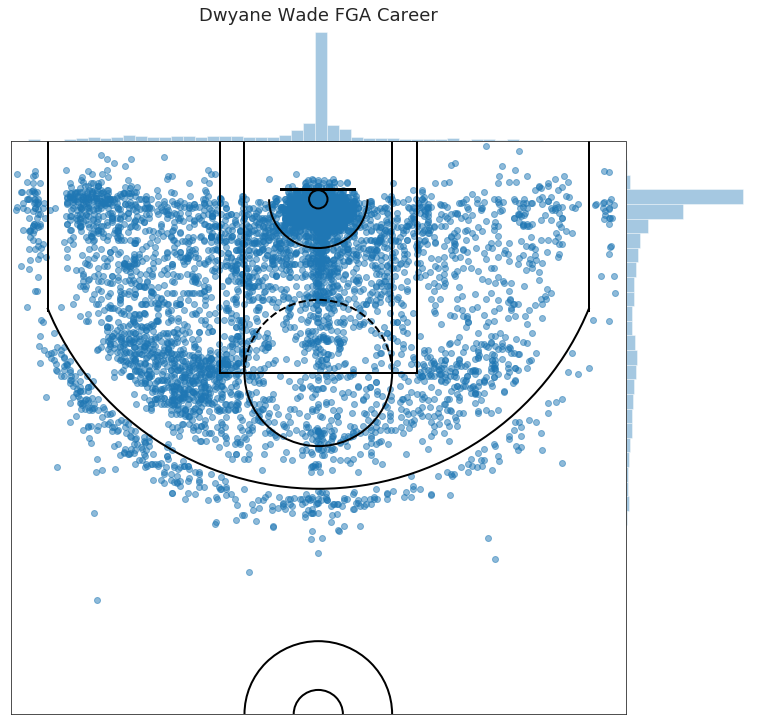

In [13]:
joint_shot_chart = sns.jointplot(shotchart_player.LOC_X, shotchart_player.LOC_Y, stat_func=None,
                                 kind='scatter', space=0, alpha=0.5)
joint_shot_chart.fig.set_size_inches(12,11)
# A joint plot has 3 Axes, the first one called ax_joint
# is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax)
# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelbottom='off', labelleft='off')
# Add a title
ax.set_title('Dwyane Wade FGA Career',
             y=1.2, fontsize=18)

In [84]:
from nba_api.stats.endpoints import playergamelog
## Lebron James
pgl = playergamelog.PlayerGameLog(player_id=2544, headers=headers)
gamelog = pgl.get_data_frames()[0]
gamelog.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22019,2544,0021900329,"DEC 06, 2019",LAL @ POR,W,34,11,23,0.478,...,6,7,8,0,1,3,1,31,21,1
1,22019,2544,0021900314,"DEC 04, 2019",LAL @ UTA,W,29,9,21,0.429,...,4,4,12,1,0,1,3,20,14,1
2,22019,2544,0021900304,"DEC 03, 2019",LAL @ DEN,W,37,9,18,0.500,...,4,6,9,0,0,4,3,25,4,1
3,22019,2544,0021900287,"DEC 01, 2019",LAL vs. DAL,L,36,11,20,0.550,...,9,9,8,4,0,6,3,25,-16,1
4,22019,2544,0021900279,"NOV 29, 2019",LAL vs. WAS,W,25,9,16,0.563,...,3,3,11,2,1,6,1,23,20,1


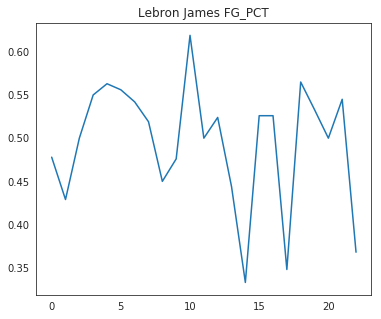

In [87]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(6,5))
plt.title('Lebron James FG_PCT')
plt.plot(range(gamelog.shape[0]), gamelog.FG_PCT)
plt.show()

In [116]:
### This is IDEA #2
### TODO: Experiment with different methods to get metrics 

def determine_stats_to_winning(player_game_data, player_name):  
    FG_PCT_THRESHOLD = 0.5
    
    stats_win_index = player_game_data.PTS + (2 * player_game_data.AST) 
    + (1.5 * player_game_data.REB) - 2 * (player_game_data.TOV + player_game_data.PF)
    + 2 * (player_game_data.STL + player_game_data.BLK)

    plt.scatter(stats_win_index, player_game_data.PLUS_MINUS, s=300, c=player_game_data.FG_PCT)
    plt.title(player_name)
    plt.show()

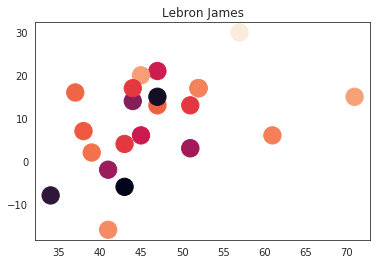

In [117]:
determine_stats_to_winning(gamelog, 'Lebron James')

In [118]:
# Make API Call for players across all seasons for a particular franchise
from nba_api.stats.endpoints import franchiseplayers
fp = franchiseplayers.FranchisePlayers(team_id=team_to_id["LAC"], headers=headers)
players = fp.get_data_frames()[0]
players.head()

,LEAGUE_ID,TEAM_ID,TEAM,PERSON_ID,PLAYER,SEASON_TYPE,ACTIVE_WITH_TEAM,GP,FGM,FGA,...,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS
0,00,1610612746,LA Clippers,15,Eric Piatkowski,Regular Season,0,616,1816,4143,...,0.841,476.0,1044.0,1520,674,1006,353.0,540.0,106.0,5269
1,00,1610612746,LA Clippers,35,Eric Riley,Regular Season,0,40,65,145,...,0.734,45.0,67.0,112,11,78,17.0,31.0,35.0,177
2,00,1610612746,LA Clippers,55,Marty Conlon,Regular Season,0,3,1,2,...,0.000,1.0,1.0,2,0,1,0.0,0.0,0.0,2
3,00,1610612746,LA Clippers,57,Doug Christie,Regular Season,0,7,5,17,...,0.667,3.0,8.0,11,8,11,3.0,5.0,1.0,13
4,00,1610612746,LA Clippers,71,Pooh Richardson,Regular Season,0,282,901,2274,...,0.684,116.0,510.0,626,1397,510,308.0,391.0,33.0,2255


In [119]:
# Build the list of players in the 2019-2020 season
active_players = players.loc[players['ACTIVE_WITH_TEAM'] == 1]
ids_per_team = active_players['PERSON_ID'].values
player_names = active_players['PLAYER'].values
players_per_team = dict(zip(ids_per_team, player_names))
print(players_per_team)

{101150: 'Lou Williams', 201976: 'Patrick Beverley', 202331: 'Paul George', 202335: 'Patrick Patterson', 202695: 'Kawhi Leonard', 203090: 'Maurice Harkless', 203210: 'JaMychal Green', 203585: 'Rodney McGruder', 1626149: 'Montrezl Harrell', 1627826: 'Ivica Zubac', 1628405: 'Johnathan Motley', 1628476: 'Derrick Walton Jr.', 1629010: 'Jerome Robinson', 1629013: 'Landry Shamet', 1629611: 'Terance Mann', 1629662: 'Mfiondu Kabengele'}


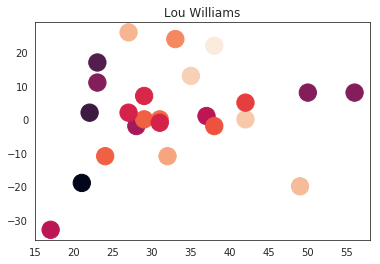

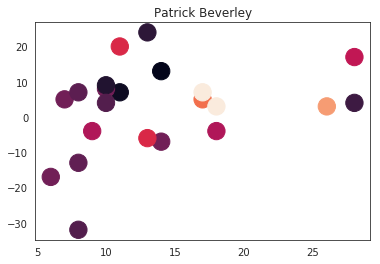

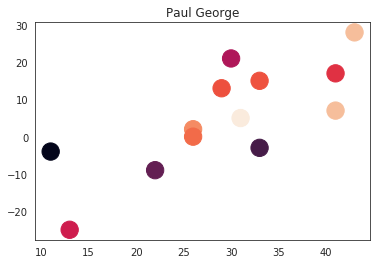

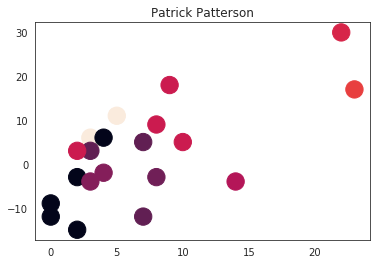

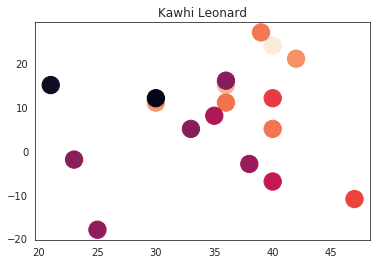

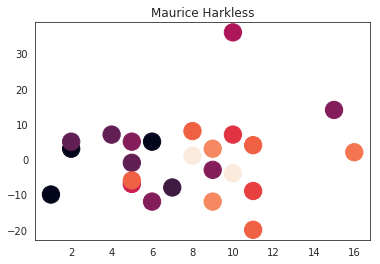

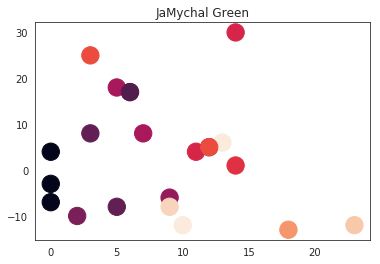

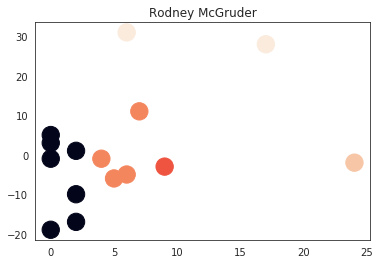

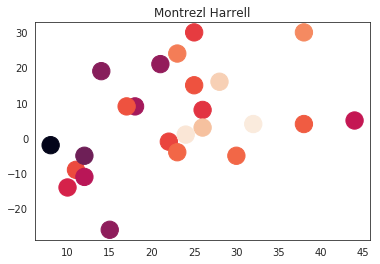

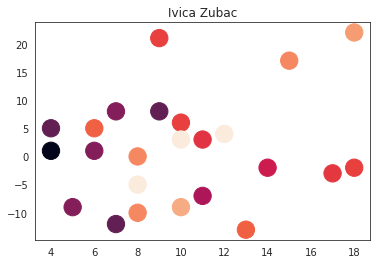

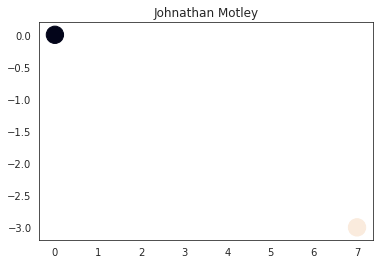

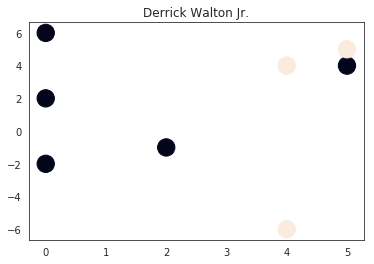

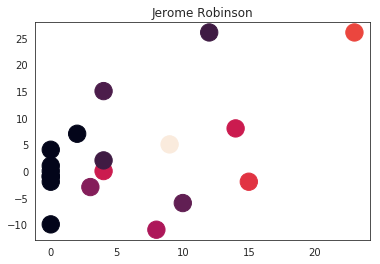

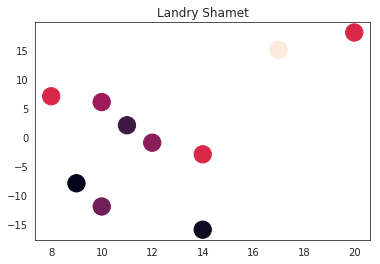

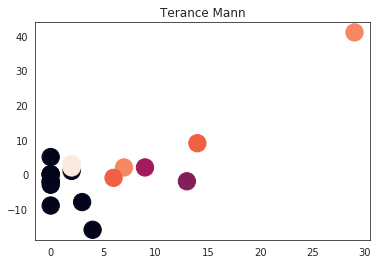

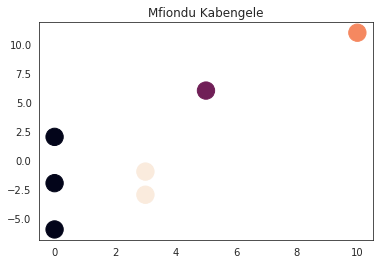

In [120]:
## Get the relationship for every player
for player in players_per_team:
    pgl = playergamelog.PlayerGameLog(player_id=player, headers=headers)
    player_game_data = pgl.get_data_frames()[0]
    determine_stats_to_winning(player_game_data, players_per_team[player])